In [1]:
import torch
import torchvision
import os

# from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

In [2]:
batch_size = 100
dataset_size = 55000
validation_size = 5000
test_size = 10000

In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Load MNIST training set
train_data = torchvision.datasets.MNIST(root=os.environ.get("DATASETS_PATH", "~/datasets"), train=True,
                                         download=True, transform=transforms.ToTensor())

# Split training set into training and validation set
train_data, validation_data = torch.utils.data.random_split(train_data,[dataset_size, validation_size])
# Load MNIST test set
test_data = torchvision.datasets.MNIST(root=os.environ.get("DATASETS_PATH", "~/datasets"), train=False,
                                        download=True, transform=transforms.ToTensor())

# Put datasets into data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=validation_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_size)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(784, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400,10, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [5]:
class evaluation(object):
    def __init__(self, test_data, criterion):
        self.test_data = test_data
        self.criterion = criterion
        self.n = 0
        self.avg_prediction = 0.

    def acc(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)
                predictions = model(x)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + predictions / self.n
                

                loss = self.criterion(self.avg_prediction, y)
                acc = 100 * (self.avg_prediction.argmax(1) == y).float().sum() / x.shape[0]

        return loss, acc

In [19]:
import sgld

np.random.seed(42)
torch.manual_seed(42)


# Model parameter
lambda_ = 1.
#lr = 3e-6

# learning_rates = [1e-6, 1e-7, 1e-8, 1e-9]
learning_rates = [6e-7, 5e-6, 4e-6, 3e-6, 2e-6, 1e-6, 9e-5, 8e-5, 7e-5, 6e-5, 5e-5]


t = 1
n = 0

error_results = []
# losses_sgld = []
# acc_sgld = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(val_loader, criterion)
    for epoch in range(50):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                loss, acc = evaluate.acc(network)


            t += 1.

    #     losses_sgld.append(loss)
    #     acc_sgld.append(acc)

        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    error_sgld = 100. - acc
    error_results.append(error_sgld)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 57.2055 - acc: 0.9500
Epoch 1 - loss: 30.3829 - acc: 0.9700
Epoch 2 - loss: 27.6055 - acc: 0.9700
Epoch 3 - loss: 25.3094 - acc: 0.9700
Epoch 4 - loss: 22.7366 - acc: 0.9800
Epoch 5 - loss: 19.7662 - acc: 0.9700
Epoch 6 - loss: 16.9395 - acc: 0.9900
Epoch 7 - loss: 14.6410 - acc: 0.9900
Epoch 8 - loss: 12.9335 - acc: 0.9900
Epoch 9 - loss: 11.5576 - acc: 0.9900
Epoch 10 - loss: 10.5312 - acc: 0.9900
Epoch 11 - loss: 9.5251 - acc: 0.9900
Epoch 12 - loss: 8.7791 - acc: 0.9900
Epoch 13 - loss: 8.0002 - acc: 0.9900
Epoch 14 - loss: 7.2921 - acc: 0.9900
Epoch 15 - loss: 6.7395 - acc: 1.0000
Epoch 16 - loss: 6.2893 - acc: 1.0000
Epoch 17 - loss: 5.9102 - acc: 0.9800
Epoch 18 - loss: 4.8733 - acc: 1.0000
Epoch 19 - loss: 4.3376 - acc: 0.9800
Epoch 20 - loss: 4.1184 - acc: 0.9900
Epoch 21 - loss: 3.9371 - acc: 1.0000
Epoch 22 - loss: 3.7535 - acc: 1.0000
Epoch 23 - loss: 3.6029 - acc: 1.0000
Epoch 24 - loss: 3.4409 - acc: 1.0000
Epoch 25 - loss: 3.3971 - acc: 0.9900
Epoch 26 - 

Epoch 24 - loss: 2.4755 - acc: 1.0000
Epoch 25 - loss: 2.5422 - acc: 0.9900
Epoch 26 - loss: 2.7691 - acc: 0.9900
Epoch 27 - loss: 3.2947 - acc: 1.0000
Epoch 28 - loss: 3.3034 - acc: 0.9900
Epoch 29 - loss: 3.0914 - acc: 1.0000
Epoch 30 - loss: 3.7632 - acc: 0.9900
Epoch 31 - loss: 3.5340 - acc: 1.0000
Epoch 32 - loss: 3.0777 - acc: 1.0000
Epoch 33 - loss: 3.4628 - acc: 0.9800
Epoch 34 - loss: 3.2767 - acc: 1.0000
Epoch 35 - loss: 3.4457 - acc: 1.0000
Epoch 36 - loss: 2.8658 - acc: 1.0000
Epoch 37 - loss: 0.9566 - acc: 1.0000
Epoch 38 - loss: 0.7001 - acc: 1.0000
Epoch 39 - loss: 0.8195 - acc: 1.0000
Epoch 40 - loss: 0.8793 - acc: 1.0000
Epoch 41 - loss: 0.8949 - acc: 1.0000
Epoch 42 - loss: 0.8219 - acc: 0.9900
Epoch 43 - loss: 0.9945 - acc: 1.0000
Epoch 44 - loss: 1.1017 - acc: 1.0000
Epoch 45 - loss: 0.9543 - acc: 1.0000
Epoch 46 - loss: 1.1166 - acc: 1.0000
Epoch 47 - loss: 1.1764 - acc: 1.0000
Epoch 48 - loss: 1.0234 - acc: 1.0000
Epoch 49 - loss: 1.4125 - acc: 1.0000
Epoch 0 - lo

Epoch 3 - loss: nan - acc: 0.1000
Epoch 4 - loss: nan - acc: 0.1000
Epoch 5 - loss: nan - acc: 0.1000
Epoch 6 - loss: nan - acc: 0.1000
Epoch 7 - loss: nan - acc: 0.1000
Epoch 8 - loss: nan - acc: 0.1000
Epoch 9 - loss: nan - acc: 0.1000
Epoch 10 - loss: nan - acc: 0.1000
Epoch 11 - loss: nan - acc: 0.1000
Epoch 12 - loss: nan - acc: 0.1000
Epoch 13 - loss: nan - acc: 0.1000
Epoch 14 - loss: nan - acc: 0.1000
Epoch 15 - loss: nan - acc: 0.1000
Epoch 16 - loss: nan - acc: 0.1000
Epoch 17 - loss: nan - acc: 0.1000
Epoch 18 - loss: nan - acc: 0.1000
Epoch 19 - loss: nan - acc: 0.1000
Epoch 20 - loss: nan - acc: 0.1000
Epoch 21 - loss: nan - acc: 0.1000
Epoch 22 - loss: nan - acc: 0.1000
Epoch 23 - loss: nan - acc: 0.1000
Epoch 24 - loss: nan - acc: 0.1000
Epoch 25 - loss: nan - acc: 0.1000
Epoch 26 - loss: nan - acc: 0.1000
Epoch 27 - loss: nan - acc: 0.1000
Epoch 28 - loss: nan - acc: 0.1000
Epoch 29 - loss: nan - acc: 0.1000
Epoch 30 - loss: nan - acc: 0.1000
Epoch 31 - loss: nan - acc:

In [20]:
error_results
# 3e-6

[tensor(2.0200),
 tensor(89.2600),
 tensor(89.2600),
 tensor(1.5400),
 tensor(2.0400),
 tensor(1.9400),
 tensor(89.2600),
 tensor(89.2600),
 tensor(89.2600),
 tensor(89.2600),
 tensor(89.2600)]

(1.2, 2.4)

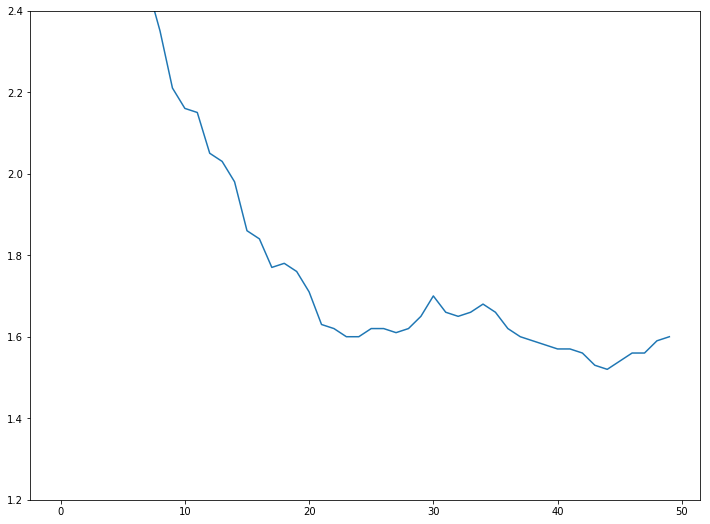

In [34]:
plt.figure(figsize=(12,9))
plt.plot(range(len(acc_sgld)),acc_sgld)
plt.ylim(1.2,2.4)
plt.xlabel('Number of Samples')
plt.ylabel('Test Set Error')

In [13]:
import psgld

np.random.seed(42)
torch.manual_seed(42)


# Model parameter
lambda_ = 1.
#lr = 3e-6

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

alpha = 0.99


t = 1
n = 0

error_psgld = []
# losses_sgld = []
# acc_sgld = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(val_loader, criterion)
    for epoch in range(50):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                loss, acc = evaluate.acc(network)


            t += 1.

    #     losses_psgld.append(loss)
    #     acc_psgld.append(acc)

        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    error = 100. - acc
    error_psgld.append(error)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

In [35]:
import psgld

np.random.seed(42)
torch.manual_seed(42)


# Model parameter
lambda_ = 1.
#lr = 3e-6

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

alpha = 0.99


t = 1
n = 0

error_psgld = []
# losses_sgld = []
# acc_sgld = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(val_loader, criterion)
    for epoch in range(50):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                loss, acc = evaluate.acc(network)


            t += 1.

    #     losses_psgld.append(loss)
    #     acc_psgld.append(acc)

        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    error = 100. - acc
    error_psgld.append(error)

In [6]:
import ksgfs

np.random.seed(42)
torch.manual_seed(42)


# Model parameter

#lr = 3e-6

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

eta = 1.
v = 0
lambda_ = 1.
l2 = 1e-3


t = 1
n = 0

error_psgld = []
# losses_ksgfs = []
# acc_ksgfs = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(val_loader, criterion)
    for epoch in range(50):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
            
            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                loss, acc = evaluate.acc(network)

            t += 1.

    #     losses_psgld.append(loss)
    #     acc_psgld.append(acc)

        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    error = 100. - acc
    error_psgld.append(error)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 35.5843 - acc: 0.9300
Epoch 1 - loss: 22.3452 - acc: 0.9500
Epoch 2 - loss: 16.6136 - acc: 0.9700
Epoch 3 - loss: 12.3814 - acc: 0.9700
Epoch 4 - loss: 9.5400 - acc: 0.9700
Epoch 5 - loss: 7.5571 - acc: 0.9700
Epoch 6 - loss: 5.9602 - acc: 0.9800
Epoch 7 - loss: 4.6991 - acc: 0.9900
Epoch 8 - loss: 3.6381 - acc: 0.9900
Epoch 9 - loss: 2.8270 - acc: 1.0000
Epoch 10 - loss: 2.1282 - acc: 1.0000
Epoch 11 - loss: 1.5317 - acc: 1.0000
Epoch 12 - loss: 1.1456 - acc: 1.0000
Epoch 13 - loss: 0.8095 - acc: 1.0000
Epoch 14 - loss: 0.5908 - acc: 1.0000
Epoch 15 - loss: 0.5063 - acc: 1.0000
Epoch 16 - loss: 0.3699 - acc: 1.0000
Epoch 17 - loss: 0.3127 - acc: 1.0000
Epoch 18 - loss: 0.2335 - acc: 1.0000
Epoch 19 - loss: 0.1929 - acc: 1.0000
Epoch 20 - loss: 0.1626 - acc: 1.0000
Epoch 21 - loss: 0.1416 - acc: 1.0000
Epoch 22 - loss: 0.1279 - acc: 1.0000
Epoch 25 - loss: 0.1021 - acc: 1.0000
Epoch 26 - loss: 0.0961 - acc: 1.0000
Epoch 27 - loss: 0.0906 - acc: 1.0000
Epoch 28 - loss: 0

Epoch 20 - loss: 11.2715 - acc: 0.9600
Epoch 21 - loss: 10.6419 - acc: 0.9800
Epoch 22 - loss: 10.0308 - acc: 0.9900
Epoch 23 - loss: 9.4492 - acc: 0.9700
Epoch 24 - loss: 8.9077 - acc: 0.9900
Epoch 25 - loss: 8.4211 - acc: 0.9900
Epoch 26 - loss: 7.9269 - acc: 0.9900
Epoch 27 - loss: 7.4620 - acc: 0.9900
Epoch 28 - loss: 7.0598 - acc: 0.9900
Epoch 30 - loss: 6.2318 - acc: 0.9900
Epoch 31 - loss: 5.8952 - acc: 0.9900
Epoch 32 - loss: 5.5556 - acc: 0.9900
Epoch 33 - loss: 5.2712 - acc: 0.9900
Epoch 34 - loss: 4.9609 - acc: 0.9900
Epoch 35 - loss: 4.5778 - acc: 0.9900
Epoch 36 - loss: 4.3337 - acc: 0.9900
Epoch 37 - loss: 4.0578 - acc: 0.9900
Epoch 38 - loss: 3.7983 - acc: 0.9900
Epoch 39 - loss: 3.6047 - acc: 0.9900
Epoch 40 - loss: 3.3435 - acc: 0.9900
Epoch 41 - loss: 3.1705 - acc: 0.9900
Epoch 42 - loss: 2.9431 - acc: 0.9900
Epoch 43 - loss: 2.7829 - acc: 0.9900
Epoch 44 - loss: 2.6189 - acc: 0.9900
Epoch 45 - loss: 2.4121 - acc: 1.0000
Epoch 46 - loss: 2.2940 - acc: 1.0000
Epoch 47 

KeyboardInterrupt: 

In [7]:
error_psgld
# 1e-2

[tensor(2.8800), tensor(2.8000), tensor(2.8800), tensor(3.), tensor(4.2200)]